A little bit of playing around with summarizing categorical variables when overplotting is a problem. Basically me thinking about [these tweets](https://twitter.com/davisjmcc/status/1227833221003350016).

In [1]:
import datashader as ds
from datashader import transfer_functions as tf
import matplotlib.pyplot as plt

import scanpy as sc
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
adata = sc.read("/Users/isaac/data/10x_mouse_13MM_processed.h5ad", backed="r")

/Users/isaac/github/anndata/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/isaac/github/anndata/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


# Summarizing it in one plot using `datashader`

Also discussed here: https://github.com/theislab/scanpy/issues/1263

In [3]:
df = sc.get.obs_df(
    adata,
    ["Sox17", "louvain"],
    obsm_keys=[("X_umap", 0), ("X_umap", 1)]
)
louvain_colors = dict(
    zip(
        adata.obs["louvain"].cat.categories, 
        adata.uns["louvain_colors"]
    )
)

In [4]:
pts = (
    ds.Canvas(500, 500)
    .points(df, "X_umap-0", "X_umap-1", agg=ds.count_cat("louvain"))
)

## Datashader default

What datashader does by default is takes the average of the RGB values for the categories under a pixel, weighted by number of samples, and calculates an alpha level based on the number of samples present. This looks like:

CPU times: user 225 ms, sys: 44.5 ms, total: 269 ms
Wall time: 269 ms


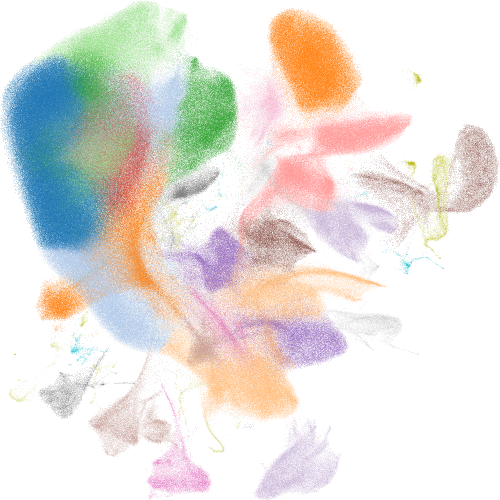

In [5]:
%%time
tf.shade(pts, color_key=louvain_colors)

I think this can be a bit confusing. For example, where the light green borders the dark blue there are darker green areas. Are these cells which would be colored dark green, or is this just the average of light green and dark blue? Similarly for purlple looking spots between red and blue.

## What if we really just want one color per pixel

We could just color each pixel by the category that showed up the most.

In [6]:
def color_by_max(pts):
    newpts = xr.zeros_like(pts)
    # pixel coords where a cell would be plotted
    x, y = np.where(pts.max(dim="louvain") != 0)
    newpts.values[x, y, pts.argmax(dim="louvain").values[x, y]] = 1
    return tf.shade(newpts, color_key=louvain_colors)

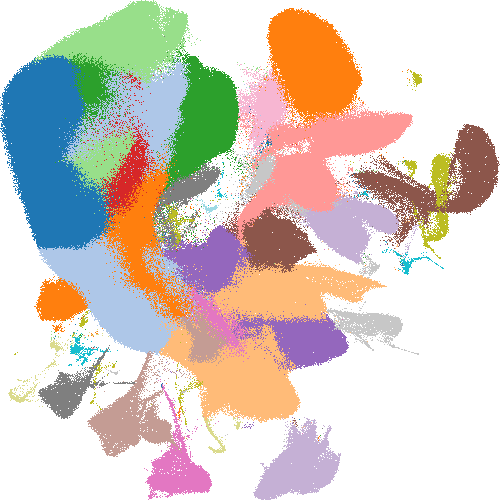

In [7]:
color_by_max(pts)

This looks weird though.

Let's instead try to use the alpha levels as well:

In [8]:
def color_by_max_w_alpha(pts):
    newpts = xr.zeros_like(pts)
    newpts[:, :, pts.argmax(dim="louvain")] = pts.sum(dim="louvain")
    return tf.shade(newpts, color_key=louvain_colors)

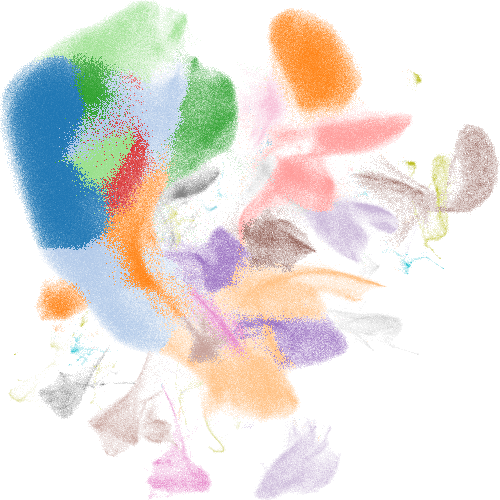

In [9]:
color_by_max_w_alpha(pts)

This is okay, but I'm note sure if it's ultimately going to be the best solution. I think multiple plots or interactivity are ulitmately going to be the answer here.

# Multiple plots:

I would ideally like to use small multiples or interactivity for this. I'm thinking about using a base image, then overlaying plots on top of it. Unfortunately, datashader seems to do this with holoviews and holoviews + bokeh seems broken in jupyterlab.

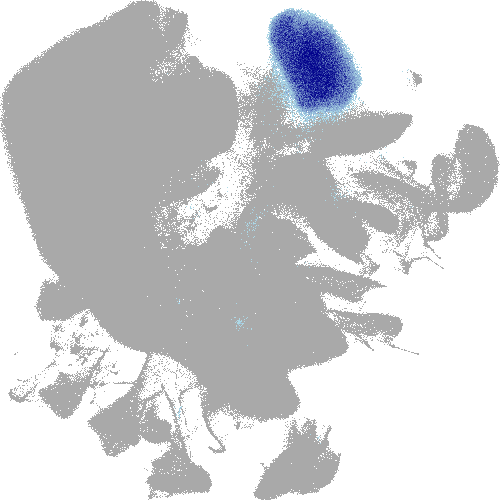

In [10]:
pt = ds.Point("X_umap-0", "X_umap-1")
cvs = ds.Canvas(500, 500, x_range=pt.compute_x_bounds(df), y_range=pt.compute_y_bounds(df))
pts = cvs.points(df, "X_umap-0", "X_umap-1", agg=ds.any())

tf.stack(
    tf.shade(pts, cmap=["darkgray"]),
    tf.shade(cvs.points(df.query("louvain == '4'"), "X_umap-0", "X_umap-1"), min_alpha=0)
)

In [11]:
def small_multiples(adata, basis, groupby, *, color=None, n_px=500):
    if color is None:
        color = groupby
    df = sc.get.obs_df(
        adata,
        [color],
        obsm_keys=[(basis, 0), (basis, 1)]
    )
    if pd.api.types.is_categorical(df[color]):
        agg = ds.count_cat(color)
        shade_color_args = {}
        if f"{color}_colors" in adata.uns:
            shade_color_args["color_key"] =  dict(zip(
                adata.obs[color].cat.categories, 
                adata.uns[f"{color}_colors"]
            ))
    else:
        agg = ds.max(color)
        shade_color_args = {}

    pt = ds.Point("X_umap-0", "X_umap-1")  # Can I use this later?
    cvs = ds.Canvas(n_px, n_px, x_range=pt.compute_x_bounds(df), y_range=pt.compute_y_bounds(df))
    base_pts = tf.shade(cvs.points(df, f"{basis}-0", f"{basis}-1", agg=ds.any()), cmap=["lightgray"])
    
    imgs = []
    for k, subdf in adata.obs.groupby(groupby):
        imgs.append(
            tf.stack(
                base_pts,
                tf.shade(cvs.points(df.loc[subdf.index], "X_umap-0", "X_umap-1", agg=agg), **shade_color_args),
                name=k,
            )
        )
    return tf.Images(*imgs)

<ipython-input-11-d11152a638fe>:9: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pd.api.types.is_categorical(df[color]):


CPU times: user 3 s, sys: 156 ms, total: 3.16 s
Wall time: 3.16 s



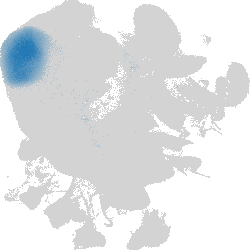
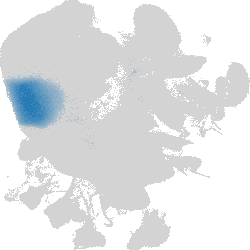
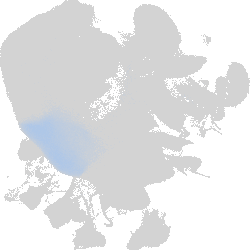
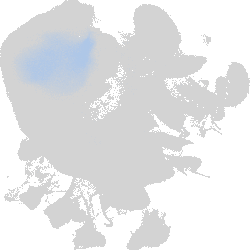
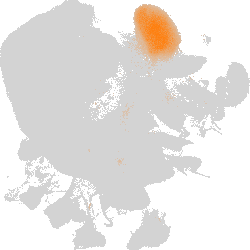
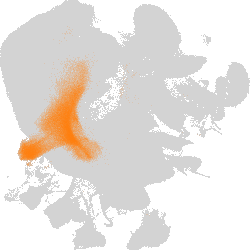
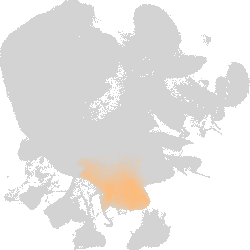
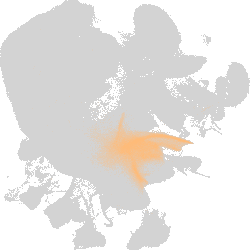
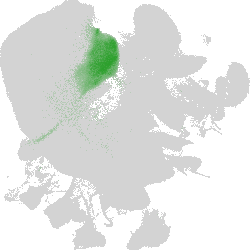
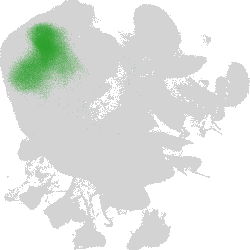
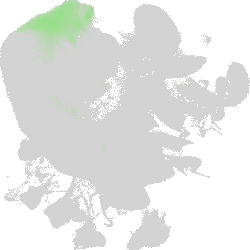
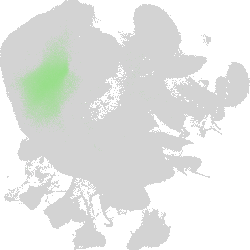
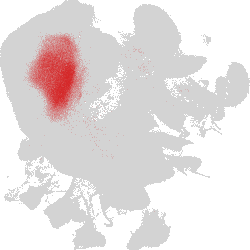
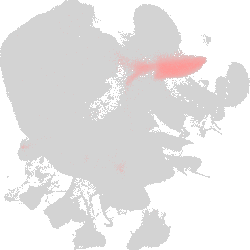
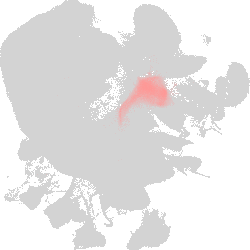
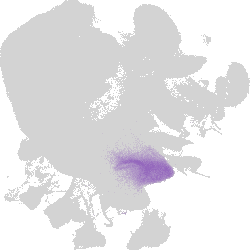
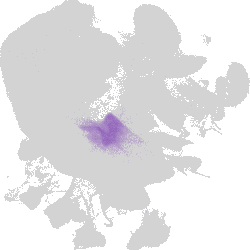
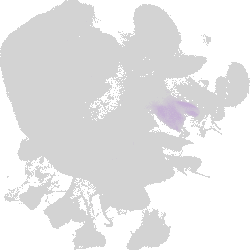
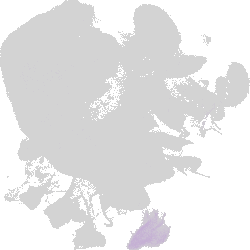
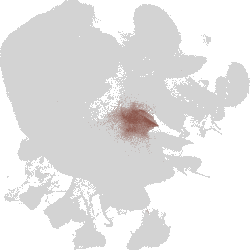
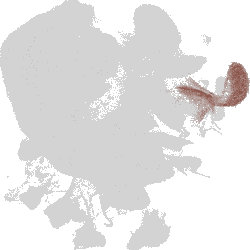
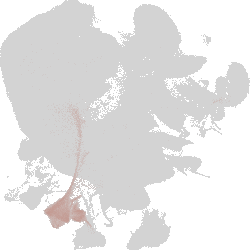
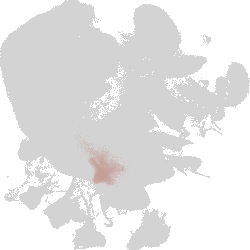
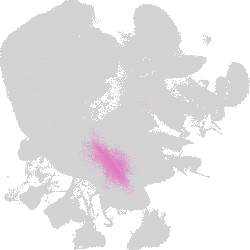
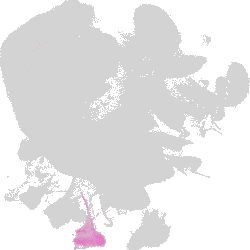
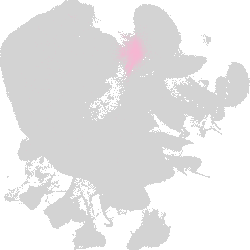
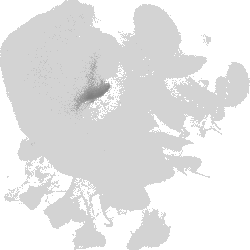
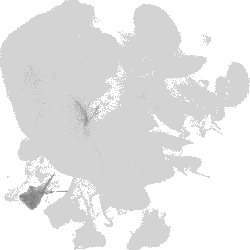
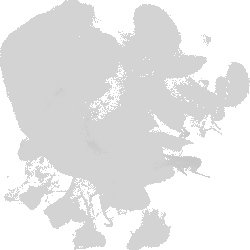
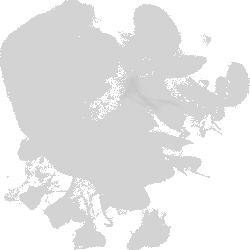
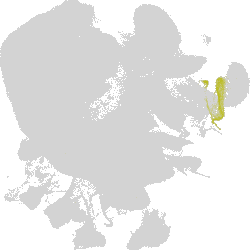
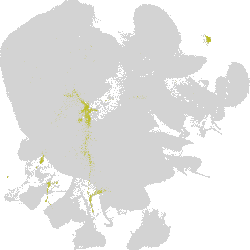
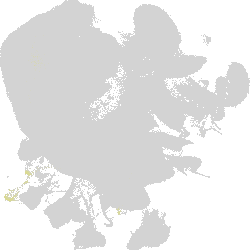
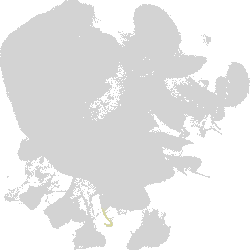
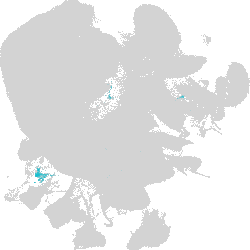
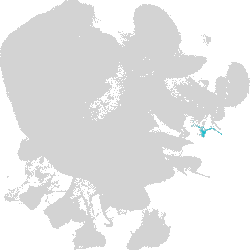
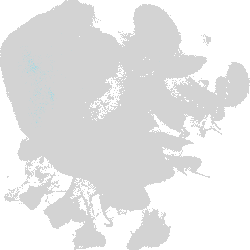
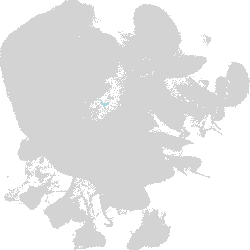

In [13]:
%%time
small_multiples(adata, "X_umap", groupby="louvain", n_px=250).cols(6)

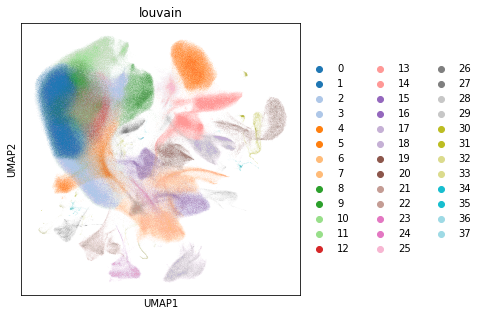

CPU times: user 12.8 s, sys: 177 ms, total: 12.9 s
Wall time: 12.9 s


In [14]:
%%time
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(adata, color="louvain")